In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
from importlib import reload

import utils2p

In [2]:
NOTEBOOK_DIR = os.getcwd()
MODULE_DIR, _ = os.path.split(NOTEBOOK_DIR)
sys.path.append(MODULE_DIR)

In [3]:
from longterm import load, utils
import longterm
from longterm.plot import videos

In [170]:
FA_R57C10_trial_dir = os.path.join(load.LOCAL_DATA_DIR, "181220_Rpr_R57C10_GC6s_tdTom", "Fly5", "002_coronal")
FA_ABO_trial_dir = os.path.join(load.LOCAL_DATA_DIR, "201014_G23xU1", "Fly1", "005_coronal")
JB_R57C10_trial_dir = os.path.join(load.LOCAL_DATA_DIR, "210301_J1xCI9", "Fly1", "002_xz")
LH_R57C10_trial_dir = os.path.join(load.LOCAL_DATA_DIR_LONGTERM, "210212", "Fly1", "cs_003")
trial_dirs = [FA_R57C10_trial_dir, FA_ABO_trial_dir, JB_R57C10_trial_dir, LH_R57C10_trial_dir]
trial_names = ["FA_R57C10", "FA_ABO", "JB_R57C10", "LH_R57C10"]

out_dir = os.path.join(load.LOCAL_DATA_DIR, "outputs", "210428_dff")

# minimal reproduction: make dff video of Florian's dff.tif

In [199]:
dff_FA_R57C10_dir = os.path.join(trial_dirs[0], "processed_FA", "dff.tif")

In [6]:
import utils_video

In [7]:
def crop_stack(stack, crop):
    if crop is not None and len(crop) == 2:
        assert crop[0]*2 < stack.shape[1]
        assert crop[1]*2 < stack.shape[2]
        stack = stack[:, crop[0]:-crop[0], crop[1]:-crop[1]]
    elif crop is not None and len(crop) == 4:
        assert crop[0] < stack.shape[1]
        assert crop[1] < stack.shape[1]
        assert crop[2] < stack.shape[2]
        assert crop[3] < stack.shape[2]
        stack = stack[:, crop[0]:crop[1], crop[2]:crop[3]]
    elif crop is None:
        return stack
    else:
        raise NotImplementedError
    return stack

def make_video_dff(dff, out_dir, video_name, frames=None, frame_rate=None, trial_dir=None,
                   vmin=None, vmax=None, pmin=0.5, pmax=99.5, blur=0, crop=None):
    dff = utils.get_stack(dff)
    if frames is None:
        frames = np.arange(dff.shape[0])
    else:
        assert np.sum(frames >= dff.shape[0]) == 0
        dff = dff[frames, :, :]
        
    dff = crop_stack(dff, crop)

    if frame_rate is None and not trial_dir is None:
        meta_data = utils2p.Metadata(utils2p.find_metadata_file(trial_dir))
        frame_rate = meta_data.get_frame_rate()
    elif frame_rate is None:
        raise NotImplementedError

    if not video_name.endswith(".mp4"):
        video_name = video_name + ".mp4"

    generator = videos.generator_dff(dff, vmin=vmin, vmax=vmax, pmin=pmin, pmax=pmax, blur=blur)
    utils_video.make_video(os.path.join(out_dir, video_name), generator, frame_rate)

In [200]:
dff_FA_R57C10 = utils.get_stack(dff_FA_R57C10_dir)

In [201]:
dff_FA_R57C10.shape

(2050, 480, 736)

In [31]:
make_video_dff(dff_FA_R57C10, out_dir=out_dir, video_name="dff_"+trial_names[0]+"_extdff_defaultv", frames=None, frame_rate=8.1,
                      vmin=None, vmax=None, crop=[80, 40])

2050it [00:09, 207.25it/s]


In [32]:
make_video_dff(dff_FA_R57C10, out_dir=out_dir, video_name="dff_"+trial_names[0]+"_extdff_vmin0", frames=None, frame_rate=8.1,
                      vmin=0, vmax=None, crop=[80, 40])

2050it [00:11, 185.43it/s]


In [38]:
make_video_dff(dff_FA_R57C10, out_dir=out_dir, video_name="dff_"+trial_names[0]+"_extdff_vmin0pmax99", frames=None, frame_rate=8.1,
                      vmin=0, pmax=99, vmax=None, crop=[80, 40])

2050it [00:11, 186.32it/s]


In [9]:
perc_99 = np.percentile(dff_FA_R57C10, 99)
dff_FA_R57C10_clip = np.clip(dff_FA_R57C10, None, perc_99)

<IPython.core.display.Javascript object>


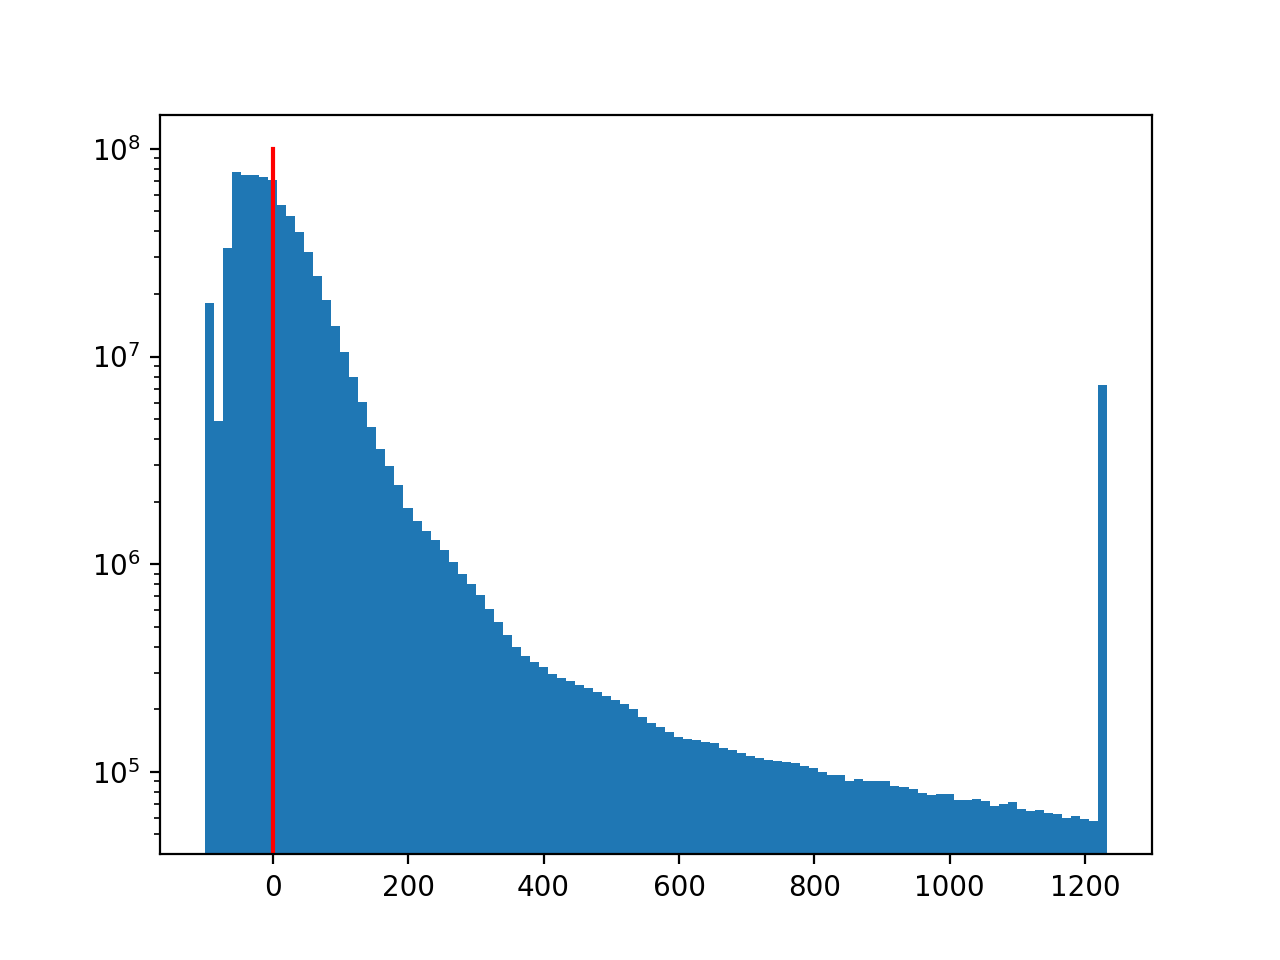

In [10]:
%matplotlib notebook
plt.hist(dff_FA_R57C10_clip.flatten(), bins=100)
plt.yscale("log")
# plt.xscale("log")
plt.plot([0, 0], [0, 10e7], "r-")

## percentage of dff that is less or equal to 0

In [11]:
np.sum(np.less_equal(dff_FA_R57C10, 0)) / dff_FA_R57C10.size * 100


54.93470804612938

In [198]:
dff_FA_R57C10.shape

NameError: name 'dff_FA_R57C10' is not defined

# compute dff using Florian's baseline

In [12]:
dff_baseline_FA_R57C10_dir = os.path.join(trial_dirs[0], "processed_FA", "baseline.tif")

In [13]:
dff_baseline_FA_R57C10 = utils.get_stack(dff_baseline_FA_R57C10_dir)

In [26]:
dff_std_FA_R57C10 = np.std(dff_FA_R57C10, axis=0)

<IPython.core.display.Javascript object>


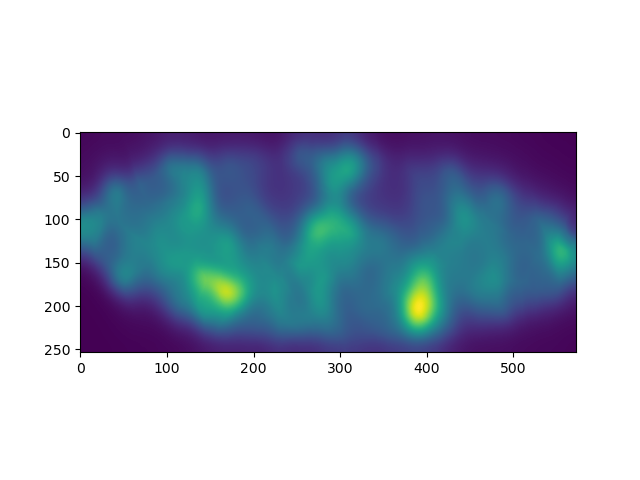

In [105]:
%matplotlib notebook
plt.imshow(dff_baseline_FA_R57C10)

<IPython.core.display.Javascript object>


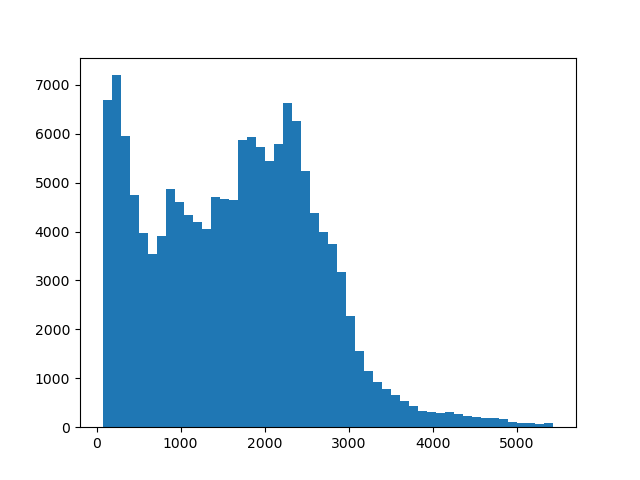

(array([6693., 7197., 5961., 4751., 3967., 3538., 3904., 4862., 4604.,
        4336., 4200., 4051., 4706., 4673., 4646., 5877., 5937., 5733.,
        5449., 5797., 6631., 6269., 5235., 4378., 4001., 3738., 3177.,
        2264., 1567., 1153.,  922.,  791.,  655.,  528.,  427.,  332.,
         314.,  300.,  305.,  261.,  227.,  215.,  192.,  184.,  171.,
         106.,   81.,   80.,   75.,   81.]),
 array([  70.16428,  177.50769,  284.8511 ,  392.1945 ,  499.5379 ,
         606.8813 ,  714.22473,  821.5681 ,  928.9115 , 1036.2549 ,
        1143.5983 , 1250.9418 , 1358.2852 , 1465.6285 , 1572.9719 ,
        1680.3153 , 1787.6587 , 1895.0022 , 2002.3456 , 2109.689  ,
        2217.0325 , 2324.3757 , 2431.7192 , 2539.0625 , 2646.406  ,
        2753.7493 , 2861.0928 , 2968.4363 , 3075.7795 , 3183.123  ,
        3290.4663 , 3397.8098 , 3505.1533 , 3612.4966 , 3719.84   ,
        3827.1833 , 3934.5269 , 4041.87   , 4149.214  , 4256.557  ,
        4363.9004 , 4471.2437 , 4578.5874 , 4685.9307 , 

In [106]:
%matplotlib notebook
plt.hist(dff_baseline_FA_R57C10.flatten(), bins=50)

<IPython.core.display.Javascript object>


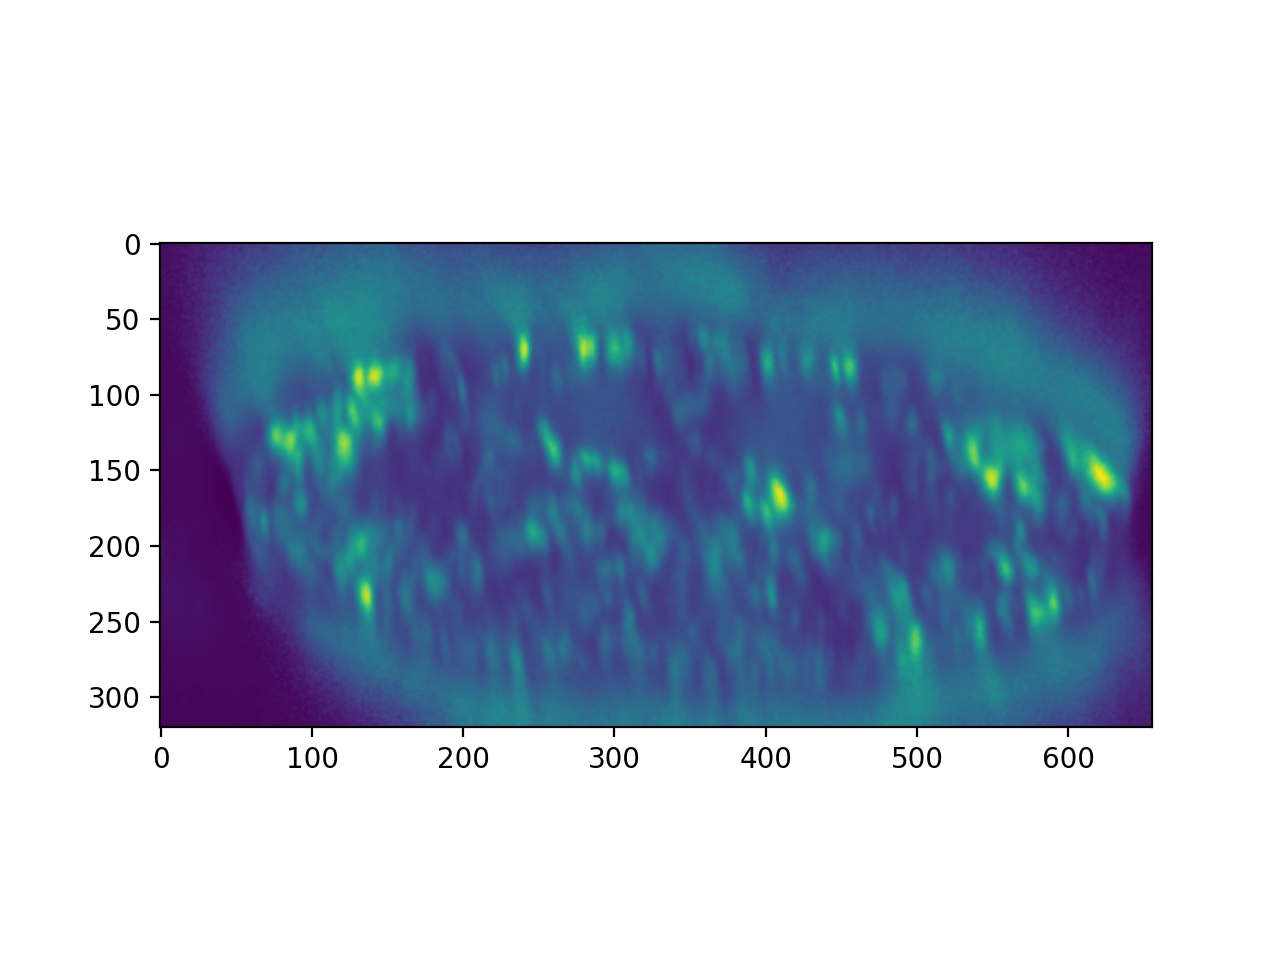

In [28]:
%matplotlib notebook
plt.imshow(dff_std_FA_R57C10[80:-80, 40:-40])

In [15]:
import pickle

In [18]:
import nely_suite

In [19]:
with open(os.path.join(trial_dirs[0], "processed_FA", "experiment_class.pkl"), "rb") as f:
    experiment_class = pickle.load(f)

In [22]:
crop = [experiment_class.crop_mask_start_dim_0, experiment_class.crop_mask_stop_dim_0, 
        experiment_class.crop_mask_start_dim_1, experiment_class.crop_mask_stop_dim_1]
crop

[137, 404, 97, 676]

In [23]:
dff_baseline_FA_R57C10.shape

(254, 573)

In [25]:
676-97

579

# try computing the baseline

In [30]:
from longterm import dff as _dff

In [165]:
green_warped = utils.get_stack(os.path.join(trial_dirs[0], "processed_FA","green_warped.tif"))

In [196]:
green_warped_std = np.quantile(green_warped, 0.001, axis=0)

<IPython.core.display.Javascript object>


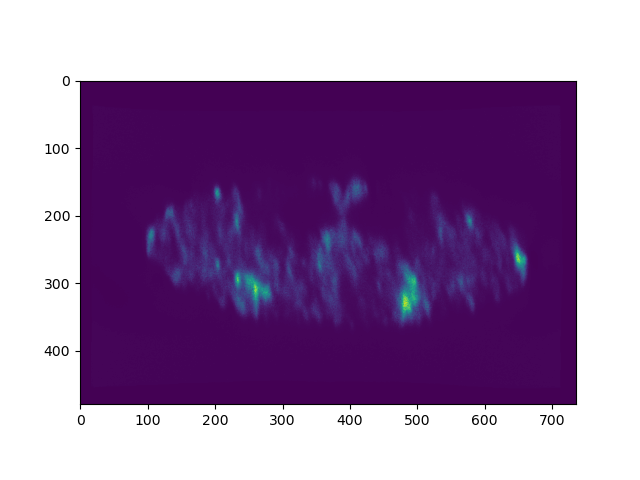

In [197]:
%matplotlib notebook
plt.imshow(green_warped_std)

In [168]:
baseline_raw = _dff._find_pixel_wise_baseline(green_warped, n=20)

In [112]:
from scipy.ndimage import gaussian_filter

<IPython.core.display.Javascript object>


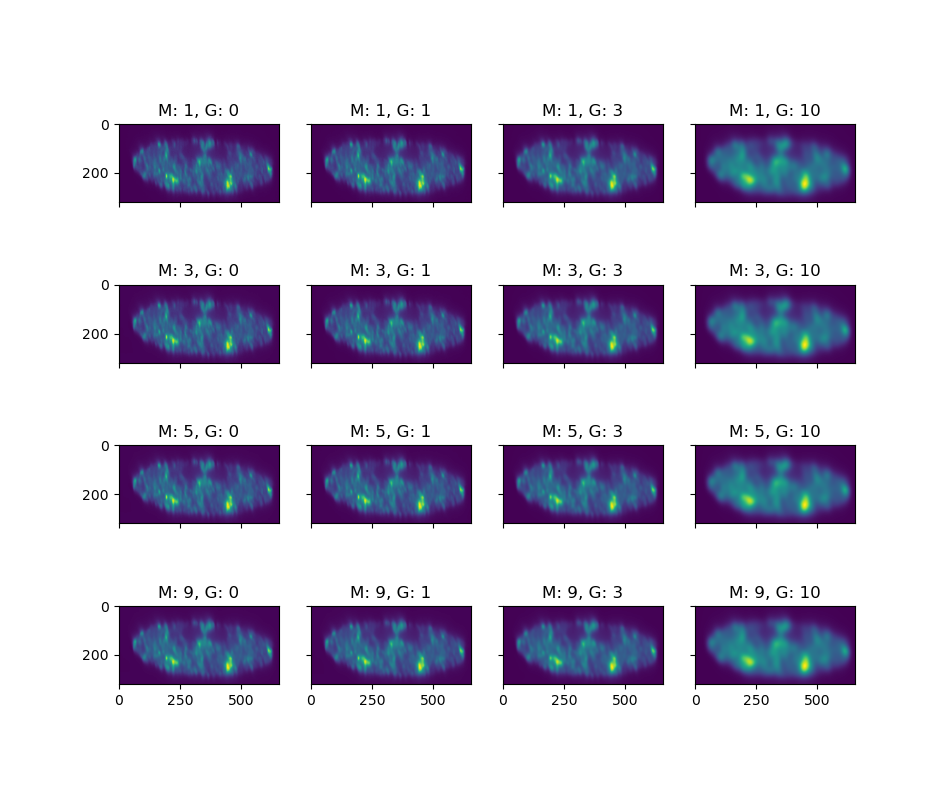

In [169]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(9.5, 8), sharex=True, sharey=True)

im = baseline_raw[80:-80, 40:-40]
sigmas_gauss = [0, 1, 3, 10]
sigmas_med = [1, 3, 5, 9]
for i_col, axs_ in enumerate(axs):
    for i_row, ax in enumerate(axs_):
        ax.imshow(gaussian_filter(medfilt(im, (sigmas_med[i_col], sigmas_med[i_col])),
                                  (sigmas_gauss[i_row], sigmas_gauss[i_row])))
        ax.set_title("M: {}, G: {}".format(sigmas_med[i_col], sigmas_gauss[i_row]))
    


<IPython.core.display.Javascript object>


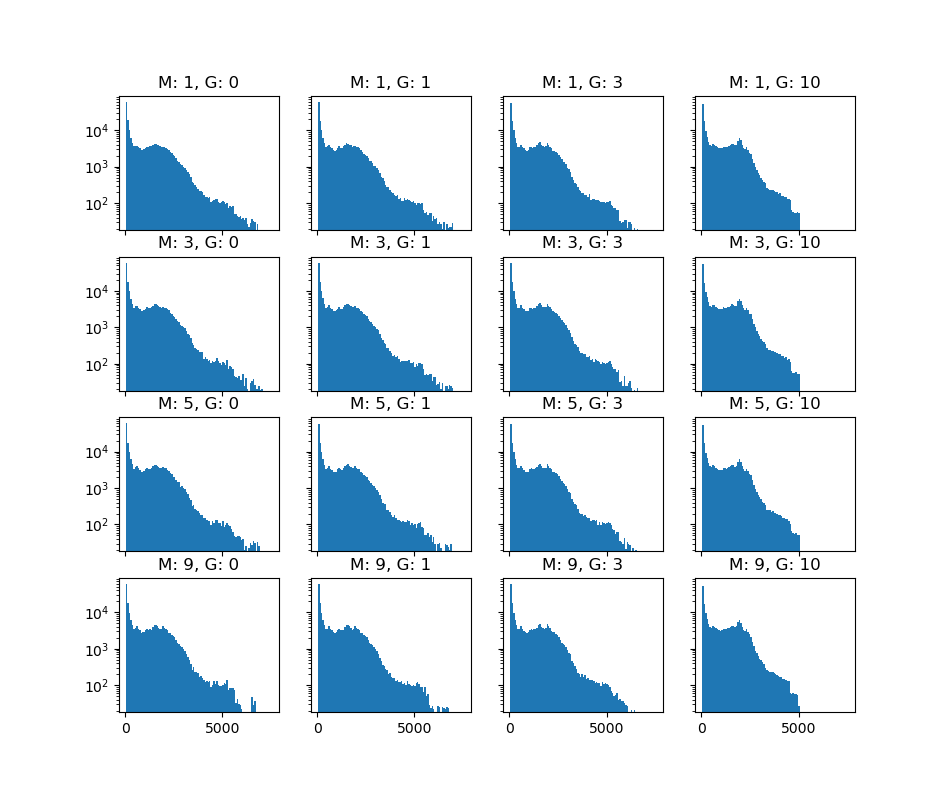

In [170]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(9.5, 8), sharex=True, sharey=True)

im = baseline_raw[80:-80, 40:-40]
sigmas_gauss = [0, 1, 3, 10]
sigmas_med = [1, 3, 5, 9]
for i_col, axs_ in enumerate(axs):
    for i_row, ax in enumerate(axs_):
        im_filt = gaussian_filter(medfilt(im, (sigmas_med[i_col], sigmas_med[i_col])),
                                  (sigmas_gauss[i_row], sigmas_gauss[i_row]))
        if i_col == 0 and i_row == 0:
            hist_out = ax.hist(im_filt.flatten(), bins=100)
        else:
            ax.hist(im_filt.flatten(), bins=hist_out[1])
        ax.set_title("M: {}, G: {}".format(sigmas_med[i_col], sigmas_gauss[i_row]))
        ax.set_yscale("log")
    



In [134]:
# stacks_med_filt = [medfilt(dff_FA_R57C10, (1, i, i)) for i in [1,3,5,9]]
stack_med_filt_3 = medfilt(green_warped, (3,1,1))

In [171]:
baseline_med_filt_3 = _dff._find_pixel_wise_baseline(stack_med_filt_3, n=20)

In [132]:
stack_med_filt_5 = medfilt(green_warped, (5,1,1))

In [172]:
baseline_med_filt_5 = _dff._find_pixel_wise_baseline(stack_med_filt_5, n=20)

<IPython.core.display.Javascript object>


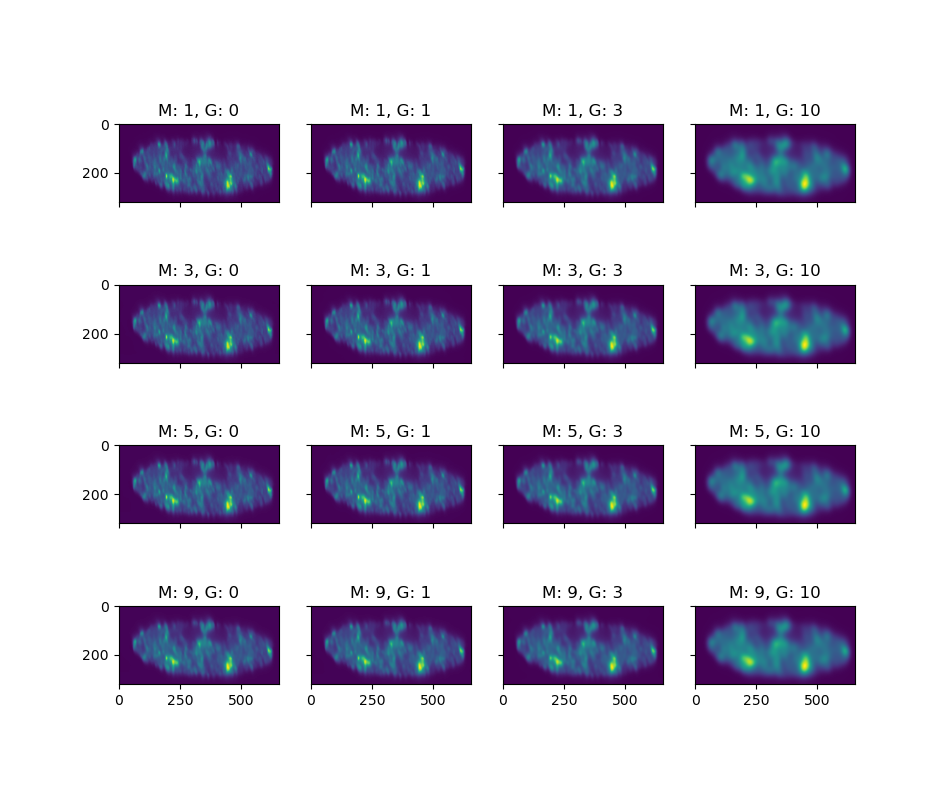

In [173]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(9.5, 8), sharex=True, sharey=True)

im = baseline_med_filt_5[80:-80, 40:-40]
sigmas_gauss = [0, 1, 3, 10]
sigmas_med = [1, 3, 5, 9]
for i_col, axs_ in enumerate(axs):
    for i_row, ax in enumerate(axs_):
        ax.imshow(gaussian_filter(medfilt(im, (sigmas_med[i_col], sigmas_med[i_col])),
                                  (sigmas_gauss[i_row], sigmas_gauss[i_row])))
        ax.set_title("M: {}, G: {}".format(sigmas_med[i_col], sigmas_gauss[i_row]))
    



<IPython.core.display.Javascript object>


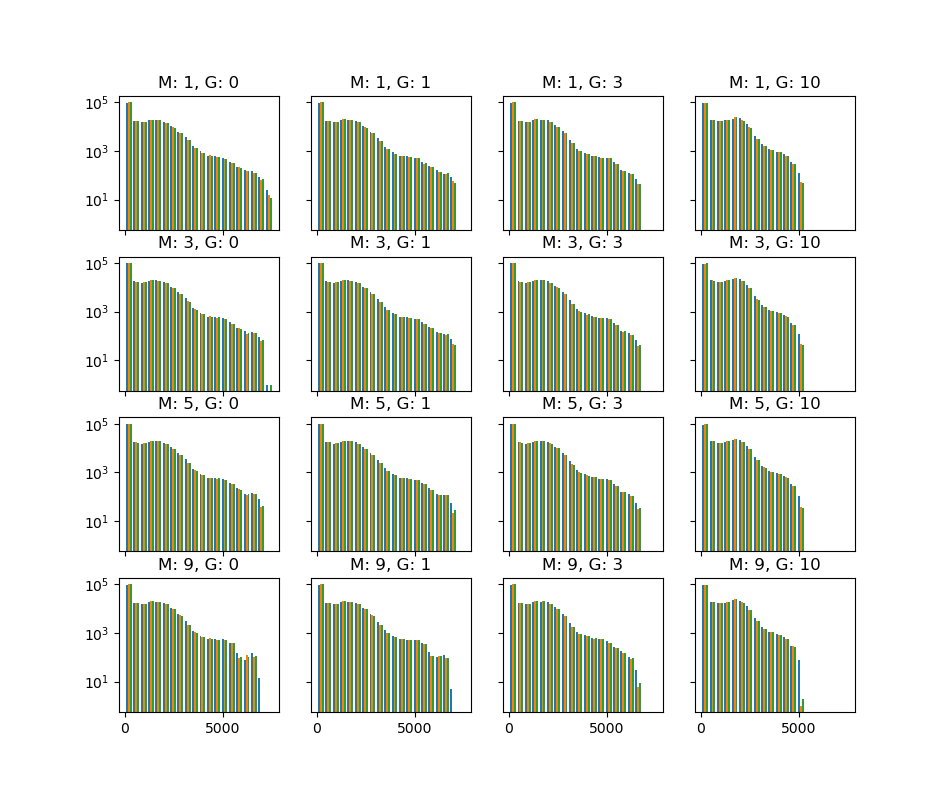

In [174]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(9.5, 8), sharex=True, sharey=True)

im = baseline_raw[80:-80, 40:-40]
im2 = baseline_med_filt_3[80:-80, 40:-40]
im3 = baseline_med_filt_5[80:-80, 40:-40]
sigmas_gauss = [0, 1, 3, 10]
sigmas_med = [1, 3, 5, 9]
for i_col, axs_ in enumerate(axs):
    for i_row, ax in enumerate(axs_):
        im_filt = gaussian_filter(medfilt(im, (sigmas_med[i_col], sigmas_med[i_col])),
                                  (sigmas_gauss[i_row], sigmas_gauss[i_row]))
        im_filt2 = gaussian_filter(medfilt(im2, (sigmas_med[i_col], sigmas_med[i_col])),
                                  (sigmas_gauss[i_row], sigmas_gauss[i_row]))
        im_filt3 = gaussian_filter(medfilt(im3, (sigmas_med[i_col], sigmas_med[i_col])),
                                  (sigmas_gauss[i_row], sigmas_gauss[i_row]))
        if i_col == 0 and i_row == 0:
            hist_out = ax.hist([im_filt.flatten(), im_filt2.flatten(), im_filt3.flatten()], bins=20)
        else:
            ax.hist([im_filt.flatten(), im_filt2.flatten(), im_filt3.flatten()], bins=hist_out[1])
        ax.set_title("M: {}, G: {}".format(sigmas_med[i_col], sigmas_gauss[i_row]))
        ax.set_yscale("log")

<IPython.core.display.Javascript object>


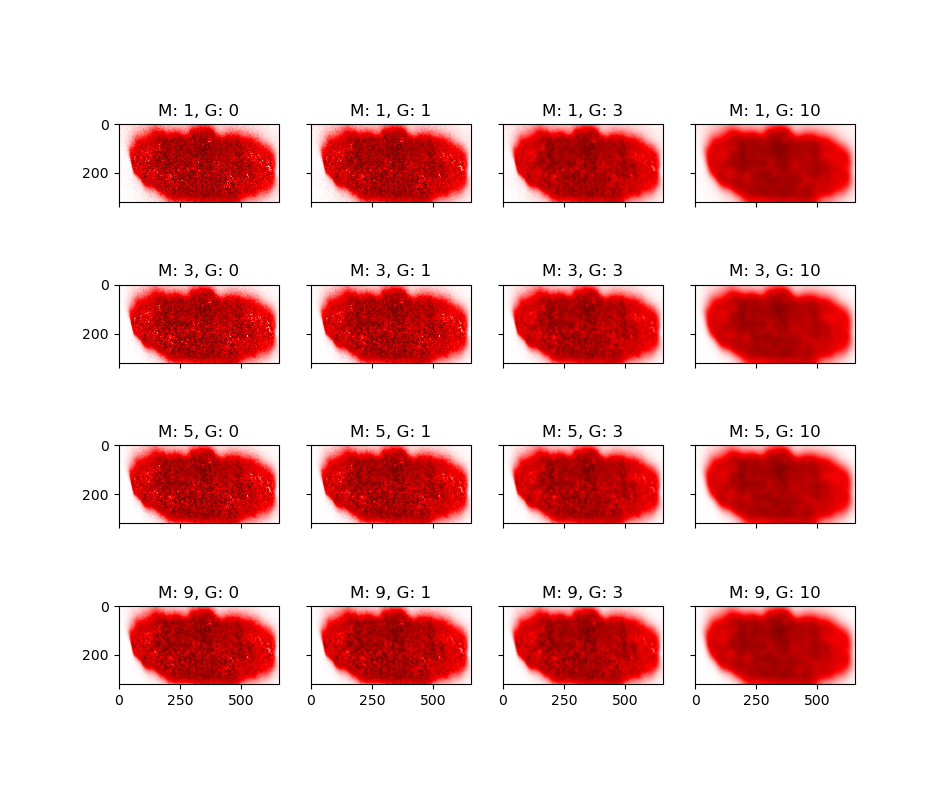

In [175]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(9.5, 8), sharex=True, sharey=True)

im = baseline_raw[80:-80, 40:-40]
im2 = baseline_med_filt_5[80:-80, 40:-40]

sigmas_gauss = [0, 1, 3, 10]
sigmas_med = [1, 3, 5, 9]
for i_col, axs_ in enumerate(axs):
    for i_row, ax in enumerate(axs_):
        im_filt = gaussian_filter(medfilt(im, (sigmas_med[i_col], sigmas_med[i_col])),
                                  (sigmas_gauss[i_row], sigmas_gauss[i_row]))
        im_filt2 = gaussian_filter(medfilt(im2, (sigmas_med[i_col], sigmas_med[i_col])),
                                  (sigmas_gauss[i_row], sigmas_gauss[i_row]))
        ax.imshow(im_filt-im_filt2, clim=[-150, 150], cmap=plt.cm.seismic)
        ax.set_title("M: {}, G: {}".format(sigmas_med[i_col], sigmas_gauss[i_row]))
    




<IPython.core.display.Javascript object>


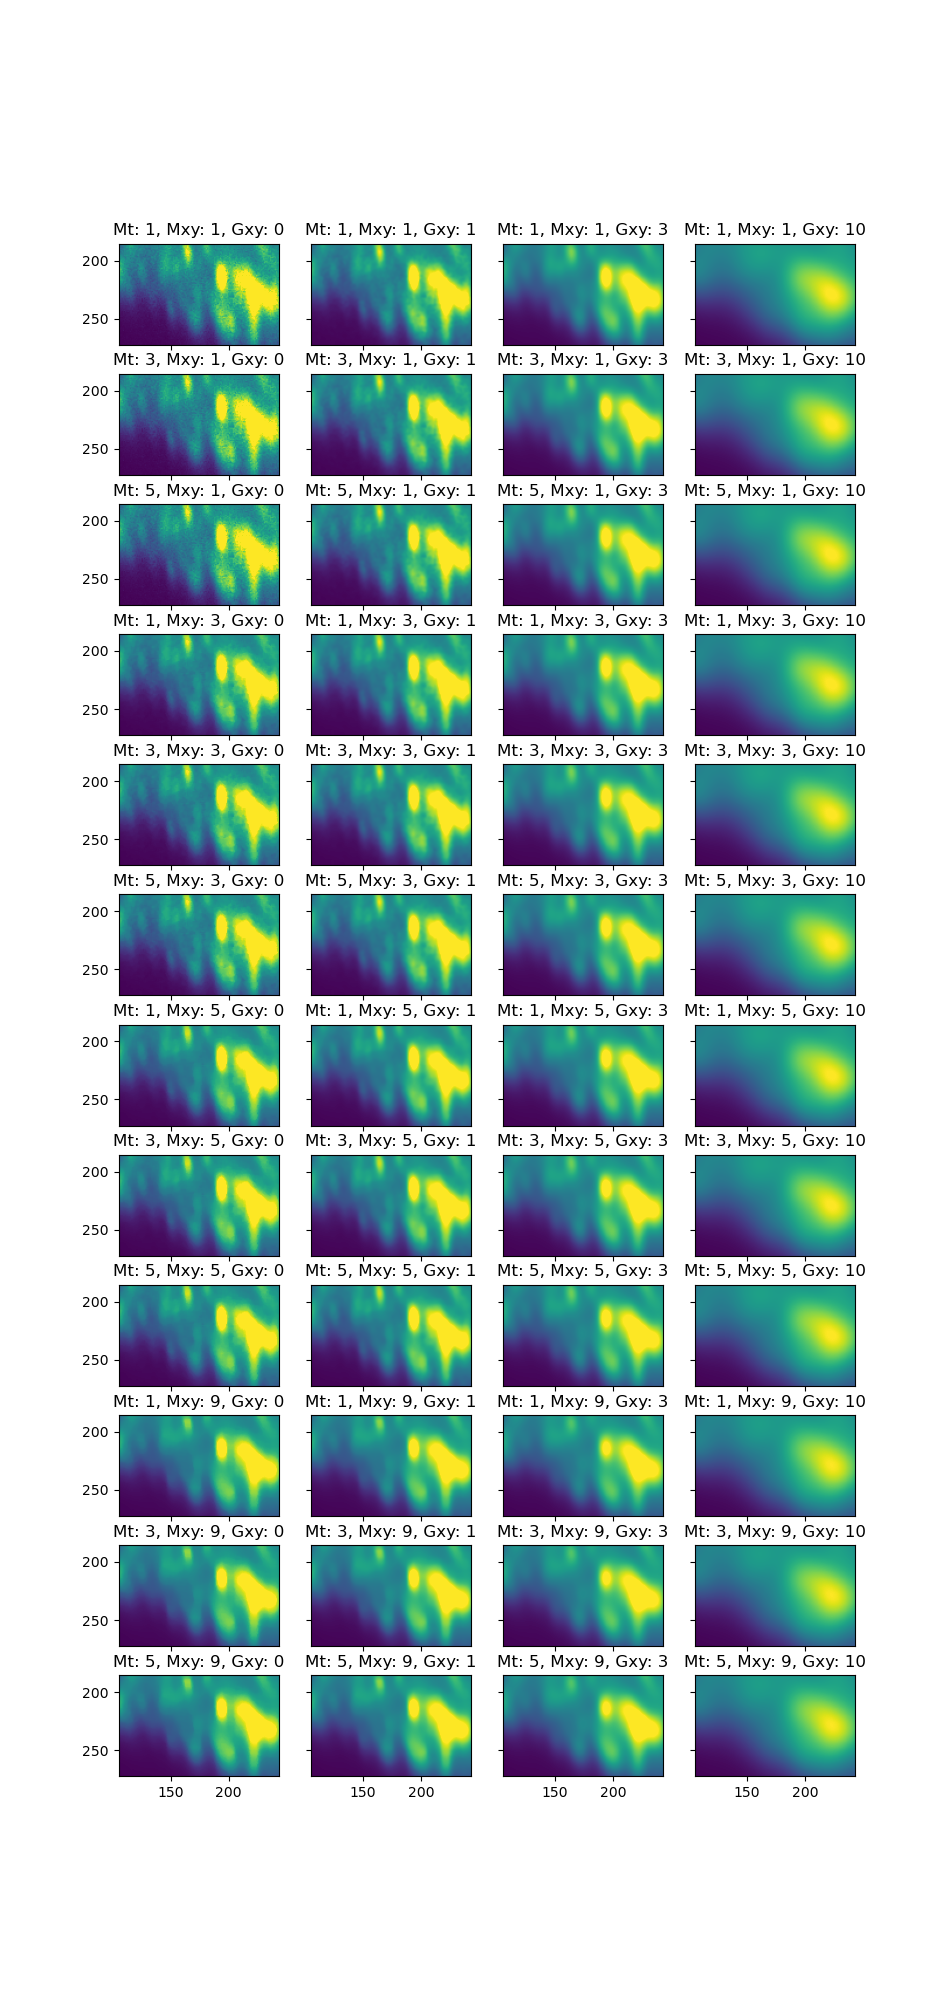

In [176]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=12, ncols=4, figsize=(9.5, 20), sharex=True, sharey=True)

im = baseline_raw[80:-80, 40:-40]
im2 = baseline_med_filt_3[80:-80, 40:-40]
im3 = baseline_med_filt_5[80:-80, 40:-40]
sigmas_gauss = [0, 1, 3, 10]
sigmas_med = [1, 3, 5, 9]
sigmas_med_pre = [1, 3, 5]
for i_row, axs_ in enumerate(axs):
    for i_col, ax in enumerate(axs_):
        if i_row % 3 == 0:
            this_im = im
        elif i_row % 3 == 1:
            this_im == im2
        elif i_row % 3 == 1:
            this_im = im3
        to_show = gaussian_filter(medfilt(this_im, (sigmas_med[i_row//3], sigmas_med[i_row//3])),
                                  (sigmas_gauss[i_col], sigmas_gauss[i_col]))
        if i_row == 0 and i_col == 0:
            clim = [np.quantile(to_show, 0.01), np.quantile(to_show, 0.99)]

        ax.imshow(to_show, clim=clim)
        ax.set_title("Mt: {}, Mxy: {}, Gxy: {}".format(sigmas_med_pre[i_row%3], sigmas_med[i_row//3], sigmas_gauss[i_col]))
    




<IPython.core.display.Javascript object>


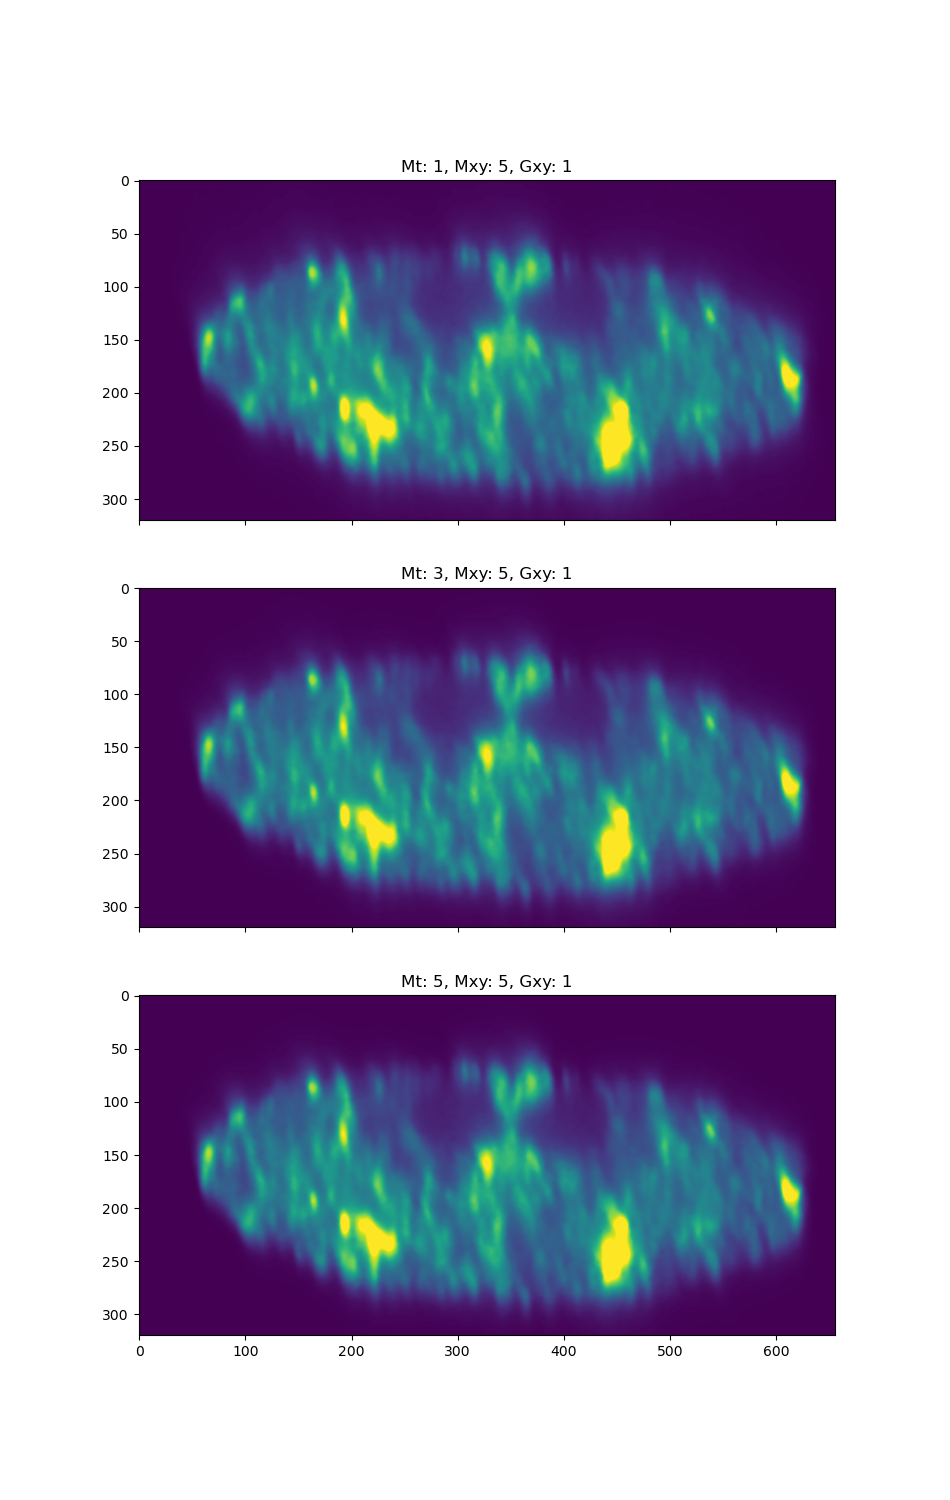

In [177]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9.5, 15), sharex=True, sharey=True)

im = baseline_raw[80:-80, 40:-40]
im2 = baseline_med_filt_3[80:-80, 40:-40]
im3 = baseline_med_filt_5[80:-80, 40:-40]
ims = [im, im2, im3]
sigmas_gauss = [0, 1, 3, 10]
sigmas_med = [1, 3, 5, 9]
sigmas_med_pre = [1, 3, 5]
for i_row, ax in enumerate(axs):

        to_show = gaussian_filter(medfilt(ims[i_row], (sigmas_med[2], sigmas_med[2])),
                                  (sigmas_gauss[1], sigmas_gauss[1]))
        if i_row == 0 and i_col == 0:
            clim = [np.quantile(to_show, 0.01), np.quantile(to_show, 0.99)]

        ax.imshow(to_show, clim=clim)
        ax.set_title("Mt: {}, Mxy: {}, Gxy: {}".format(sigmas_med_pre[i_row], sigmas_med[2], sigmas_gauss[1]))
    





# compute dff with different baselines. For now without the median filter in the end

In [78]:
from tqdm import tqdm

In [178]:
baselines = [[gaussian_filter(medfilt(baseline_raw[80:-80, 40:-40], (sigma_med, sigma_med)),
                              (sigma_gauss, sigma_gauss)) 
              for sigma_gauss in [0,1,3]]
             for sigma_med in [1,3,5]]

In [179]:
baselines_med_filt3 = [[gaussian_filter(medfilt(baseline_med_filt_3[80:-80, 40:-40], (sigma_med, sigma_med)),
                              (sigma_gauss, sigma_gauss)) 
              for sigma_gauss in [0,1,3]]
             for sigma_med in [1,3,5]]

In [180]:
baselines_med_filt5 = [[gaussian_filter(medfilt(baseline_med_filt_5[80:-80, 40:-40], (sigma_med, sigma_med)),
                              (sigma_gauss, sigma_gauss)) 
              for sigma_gauss in [0,1,3]]
             for sigma_med in [1,3,5]]

In [186]:
dffs = [[_dff._compute_dff(green_warped[:, 80:-80, 40:-40], baseline, apply_filter=True)
         for baseline in tqdm(bs)]
        for bs in baselines]

 33%|███▎      | 1/3 [02:01<04:02, 121.38s/it]

KeyboardInterrupt: 

In [192]:
baseline = gaussian_filter(medfilt(baseline_med_filt_5[80:-80, 40:-40], (9, 9)),(10, 10))
dff = _dff._compute_dff(green_warped[:, 80:-80, 40:-40], baseline=baseline, apply_filter=True)

In [144]:
dffs_mde_filt_3 = [[_dff._compute_dff(green_warped[:, 80:-80, 40:-40], baseline, apply_filter=True)
         for baseline in tqdm(bs)]
        for bs in baselines_med_filt3]

100%|██████████| 3/3 [06:01<00:00, 120.33s/it]


In [145]:
dffs_mde_filt_5 = [[_dff._compute_dff(green_warped[:, 80:-80, 40:-40], baseline, apply_filter=True)
         for baseline in tqdm(bs)]
        for bs in baselines_med_filt5]

100%|██████████| 3/3 [06:00<00:00, 120.32s/it]


In [125]:
dff_names = [["M: {}, G: {}".format(sigma_med, sigma_gauss)
              for sigma_gauss in [0,1,3]]
             for sigma_med in [1,3,5]]

In [126]:
def make_multiple_video_dff(dffs, out_dir, video_name, dff_names=None, frames=None, frame_rate=None, trial_dir=None,
                            vmin=None, vmax=None, pmin=0.5, pmax=99.5, blur=0, share_lim=True):
    if not isinstance(dffs, list):
        dffs = [dffs]
        dff_names = [dff_names]
    if not isinstance(dffs[0], list):
        dffs = [dffs]
        dff_names = [dff_names]
    
    dffs = [[utils.get_stack(dff) for dff in dffs_] for dffs_ in dffs]
    if frames is None:
        frames = np.arange(dffs[0][0].shape[0])
    else:
        assert np.sum(frames >= dffs[0][0].shape[0]) == 0
        dffs = [[dff[frames, :, :] for dff in dffs_] for dffs_ in dffs]
        
    if share_lim:
        vmins = [[np.percentile(dff, pmin) if vmin is None else vmin for dff in dffs_] for dffs_ in dffs]
        vmaxs = [[np.percentile(dff, pmax) if vmax is None else vmax for dff in dffs_] for dffs_ in dffs]
        vmin = np.min(vmins)
        vmax = np.max(vmax)

    if frame_rate is None and not trial_dir is None:
        meta_data = utils2p.Metadata(utils2p.find_metadata_file(trial_dir))
        frame_rate = meta_data.get_frame_rate()
    elif frame_rate is None:
        raise NotImplementedError

    if not video_name.endswith(".mp4"):
        video_name = video_name + ".mp4"

    generators = [[videos.generator_dff(dff, vmin=vmin, vmax=vmax, pmin=pmin, pmax=pmax, blur=blur) for dff in dffs_] for dffs_ in dffs]
    if dff_names[0][0] is not None:
        generators = [[utils_video.generators.add_text(generator, text=text, pos=(10,50)) 
                       for (generator, text) in zip(generator_rows, text_rows)]
                      for (generator_rows, text_rows) in zip(generators, dff_names)]
    generator_rows = [utils_video.generators.stack(generator_row, axis=1) for generator_row in generators]
    generator = utils_video.generators.stack(generator_rows, axis=0)
    utils_video.make_video(os.path.join(out_dir, video_name), generator, frame_rate)

In [127]:
out_dir_NAS = os.path.join(load.NAS_DIR_JB, "_", "210428_dff")

<IPython.core.display.Javascript object>


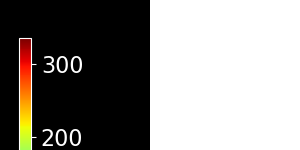


0it [00:00, ?it/s]
16it [00:00, 152.85it/s]
32it [00:00, 145.07it/s]
47it [00:00, 144.67it/s]
62it [00:00, 145.06it/s]
77it [00:00, 145.68it/s]
92it [00:00, 145.93it/s]
107it [00:00, 146.25it/s]
122it [00:00, 145.97it/s]
137it [00:00, 145.42it/s]
152it [00:01, 144.92it/s]
167it [00:01, 144.25it/s]
182it [00:01, 143.84it/s]
197it [00:01, 144.25it/s]
212it [00:01, 143.46it/s]
227it [00:01, 142.85it/s]
242it [00:01, 142.10it/s]
257it [00:01, 141.81it/s]
272it [00:01, 141.73it/s]
287it [00:01, 142.49it/s]
302it [00:02, 142.39it/s]
317it [00:02, 141.79it/s]
332it [00:02, 141.57it/s]
347it [00:02, 141.75it/s]
362it [00:02, 141.56it/s]
377it [00:02, 142.11it/s]
392it [00:02, 142.51it/s]
407it [00:02, 142.48it/s]
422it [00:02, 142.51it/s]
437it [00:03, 142.75it/s]
452it [00:03, 142.88it/s]
467it [00:03, 141.75it/s]
482it [00:03, 142.30it/s]
497it [00:03, 142.42it/s]
512it [00:03, 142.32it/s]
527it [00:03, 142.66it/s]
542it [00:03, 142.84it/s]
557it [00:03, 142.35it/s]
572it [00:03, 141.45it/s

In [193]:
make_multiple_video_dff(dff, out_dir=out_dir_NAS, video_name="dff_FA_R57C10_l20_mt5m9g10_vmin0pmax99",
                        dff_names="Mt: 5, M: 9, G: 10", frame_rate=8.1, trial_dir=None,
                        vmin=0, pmax=99, blur=0, share_lim=False)

<IPython.core.display.Javascript object>


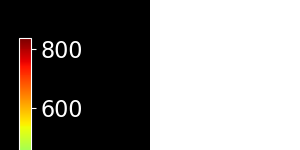

<IPython.core.display.Javascript object>


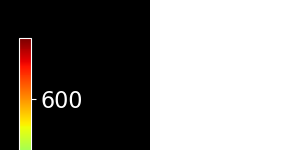

<IPython.core.display.Javascript object>


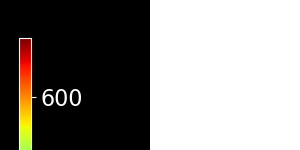

<IPython.core.display.Javascript object>


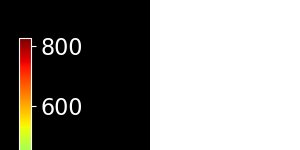

<IPython.core.display.Javascript object>


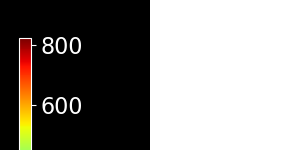

<IPython.core.display.Javascript object>


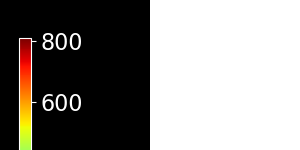

<IPython.core.display.Javascript object>


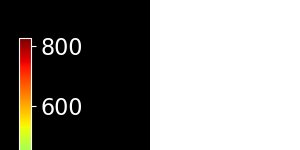

<IPython.core.display.Javascript object>


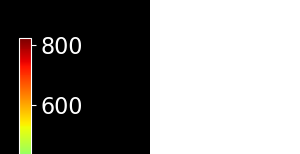

<IPython.core.display.Javascript object>


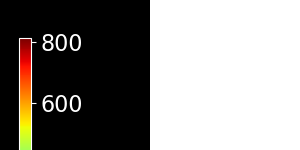

100it [00:07, 14.27it/s]


In [183]:
make_multiple_video_dff(dffs, out_dir=out_dir_NAS, video_name="dff_FA_R57C10_varybaselinel20_vmin0pmax99",
                        dff_names=dff_names, frames=np.arange(100), frame_rate=8.1, trial_dir=None,
                        vmin=0, pmax=99, blur=0, share_lim=False)

<IPython.core.display.Javascript object>


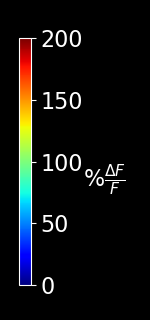

<IPython.core.display.Javascript object>


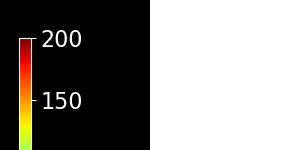

<IPython.core.display.Javascript object>


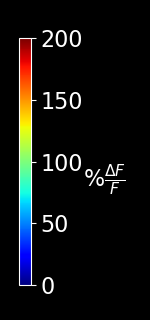

<IPython.core.display.Javascript object>


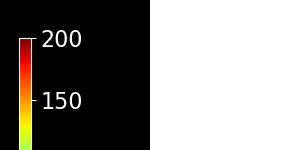

<IPython.core.display.Javascript object>


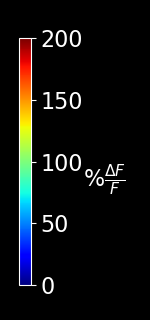

<IPython.core.display.Javascript object>


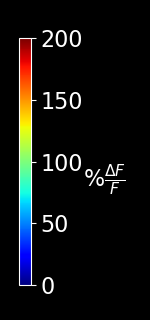

<IPython.core.display.Javascript object>


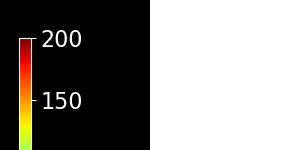

<IPython.core.display.Javascript object>


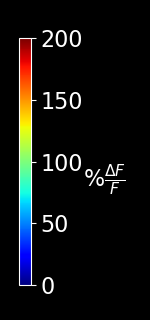

<IPython.core.display.Javascript object>


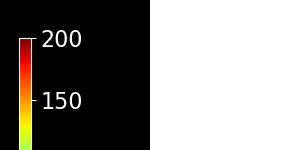

100it [00:07, 13.87it/s]


In [184]:
make_multiple_video_dff(dffs, out_dir=out_dir_NAS, video_name="dff_FA_R57C10_varybaselinel20_vmin0vmax200",
                        dff_names=dff_names, frames=np.arange(100), frame_rate=8.1, trial_dir=None,
                        vmin=0, vmax=200, blur=0, share_lim=False)

<IPython.core.display.Javascript object>


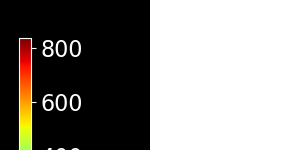

<IPython.core.display.Javascript object>


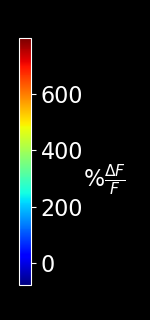

<IPython.core.display.Javascript object>


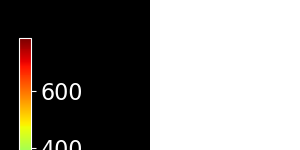

<IPython.core.display.Javascript object>


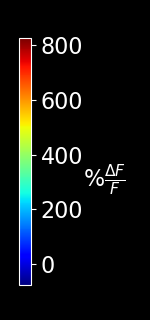

<IPython.core.display.Javascript object>


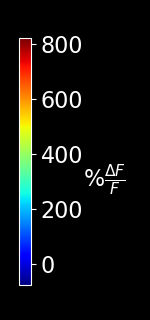

<IPython.core.display.Javascript object>


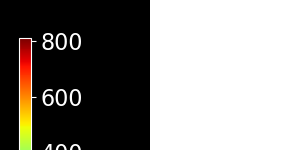

<IPython.core.display.Javascript object>


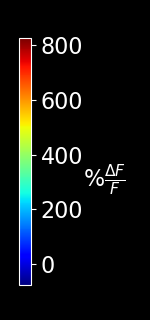

<IPython.core.display.Javascript object>


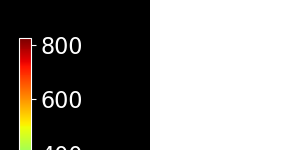

<IPython.core.display.Javascript object>


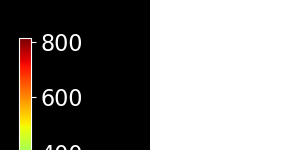

100it [00:05, 17.00it/s]


In [185]:
make_multiple_video_dff(dffs, out_dir=out_dir_NAS, video_name="dff_FA_R57C10_varybaselinel20_pmin1pmax99",
                        dff_names=dff_names, frames=np.arange(100), frame_rate=8.1, trial_dir=None,
                        pmin=1, pmax=99, blur=0, share_lim=False)

<IPython.core.display.Javascript object>


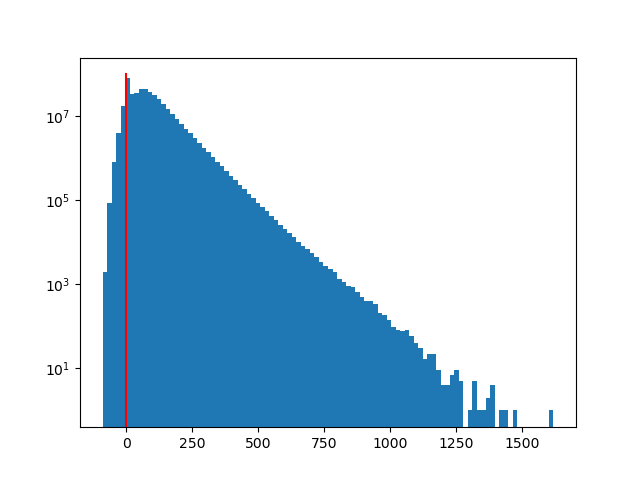

In [131]:
%matplotlib notebook
plt.hist(dffs[0][0].flatten(), bins=100)
plt.yscale("log")
# plt.xscale("log")
plt.plot([0, 0], [0, 10e7], "r-")

# improve dff baseline for denoised data (and normal data) by removing the background

In [216]:
# processed_dir = os.path.join(trial_dirs[3], load.PROCESSED_FOLDER)
processed_dir = os.path.join(load.NAS_DIR, "LH", "210423_caffeine", "J1M5_fly2", load.PROCESSED_FOLDER)

In [217]:
processed_dir

'/mnt/NAS/LH/210423_caffeine/J1M5_fly2/processed'

In [221]:
dff_baseline = utils.get_stack(os.path.join(processed_dir, "dff_baseline.tif"))[32:-32, :]  # [80:400, 128:608]
# dff_baseline_denoised = utils.get_stack(os.path.join(processed_dir, "dff_denoised_baseline.tif"))
dff_baseline_denoised = utils.get_stack(os.path.join(processed_dir, "dff_baseline_denoised.tif"))


# dff_baseline_denoised = utils.get_stack(os.path.join(processed_dir, "dff_denoised_baseline_prefilt_10.tif"))

In [222]:
print(dff_baseline.shape)
print(dff_baseline_denoised.shape)

(320, 448)
(320, 448)


In [252]:
from scipy.ndimage.filters import gaussian_filter
def find_dff_mask(baseline, otsu_frac=0.5, kernel=np.ones((20,20)), sigma=20):
    baseline_filt = gaussian_filter(baseline, sigma=(sigma, sigma))
    mask = binary_closing(baseline_filt > otsu_frac*threshold_otsu(baseline_filt), selem=kernel)
    return mask

<IPython.core.display.Javascript object>


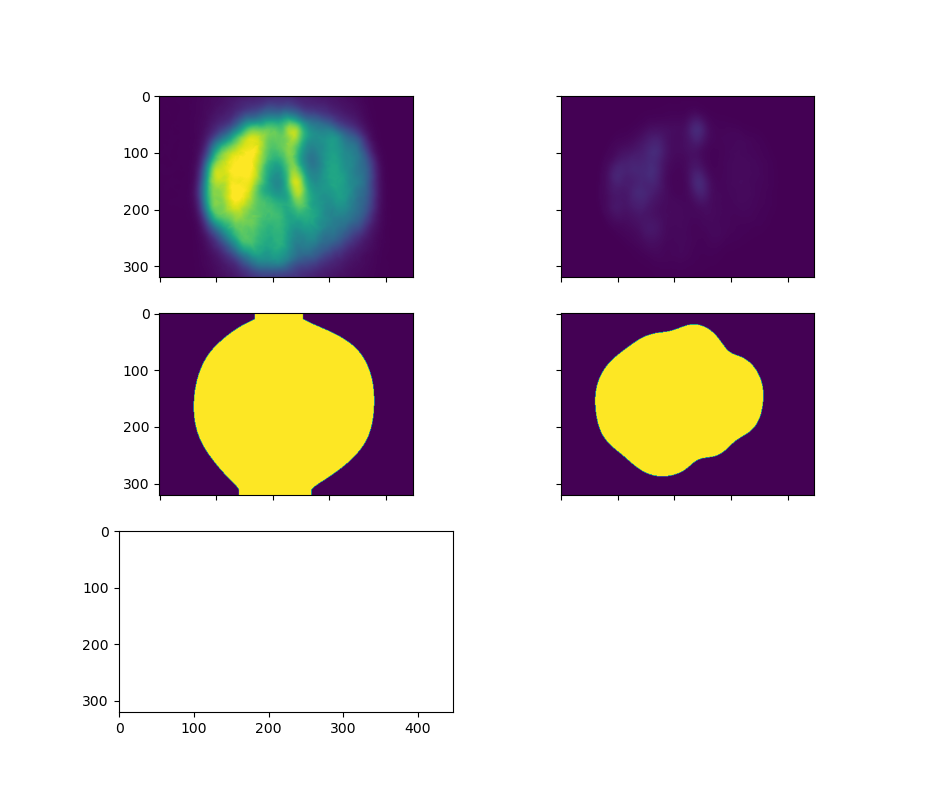

(-0.5, 447.5, 319.5, -0.5)

In [253]:
%matplotlib notebook
thres_R57C10 = 0.4
thres_ABO = 0.4
thres = thres_R57C10  # thres_ABO  # thres_R57C10
selem1 = np.ones((30,30))
selem2 = np.ones((30,30))

clim = [0, np.quantile(dff_baseline, .99)]
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9.5, 8), sharex=True, sharey=True)  # , sharex="row", sharey="row")  # , sharey="col", sharex="col")
axs[0,0].imshow(dff_baseline, clim=clim)
axs[0,1].imshow(dff_baseline_denoised, clim=clim)
# axs[1,0].imshow(dff_baseline_denoised-dff_baseline, clim=[-100, 100], cmap=plt.cm.seismic)
axs[1,0].imshow(find_dff_mask(dff_baseline))
axs[1,1].imshow(find_dff_mask(dff_baseline_denoised))
# axs[2,0].hist([dff_baseline.flatten(), dff_baseline_denoised.flatten()], bins=20)
axs[2,1].axis("off")

In [96]:
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing
import skimage.morphology

In [82]:
mask = dff_baseline_denoised > 0.5*threshold_otsu(dff_baseline_denoised)

In [89]:
mask_opened = skimage.morphology.binary_closing(mask, selem=np.ones((50,50)))
# mask_opened = skimage.morphology.binary_dilation(mask, selem=np.ones((20,20)))
# mask_opened = skimage.morphology.binary_erosion(mask_opened, selem=np.ones((20,20)))

<IPython.core.display.Javascript object>


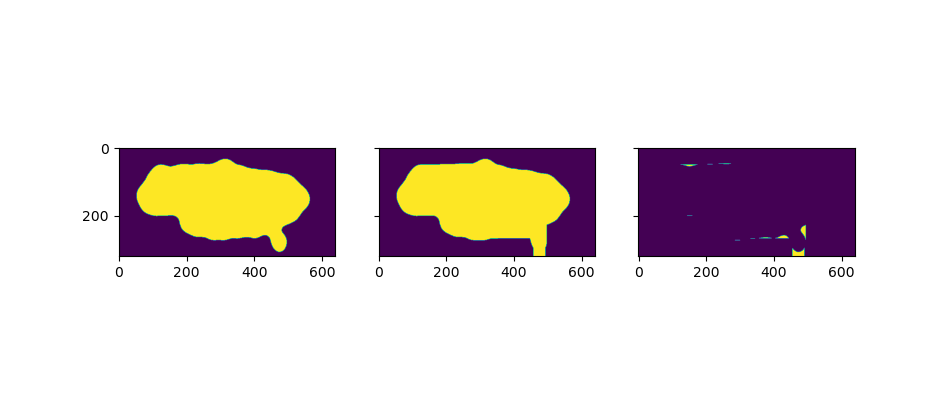

In [90]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9.5, 4), sharex=True, sharey=True)
axs[0].imshow(mask)
axs[1].imshow(mask_opened)
axs[2].imshow(mask_opened^mask)

## show baselines

In [202]:
base_path = "/home/jbraun/data/outputs/210428_dff"
baseline_0 = os.path.join(base_path, "step_3_0_0_0.npy")
baseline_3 = os.path.join(base_path, "step_3_0_2_0.npy")
baseline_10 = os.path.join(base_path, "step_3_0_3_0.npy")
baseline_med = os.path.join(base_path, "step_3_3_0_0.npy")

In [203]:
baseline_0 = np.load(baseline_0)
baseline_3 = np.load(baseline_3)
baseline_10 = np.load(baseline_10)
baseline_med = np.load(baseline_med)

<IPython.core.display.Javascript object>


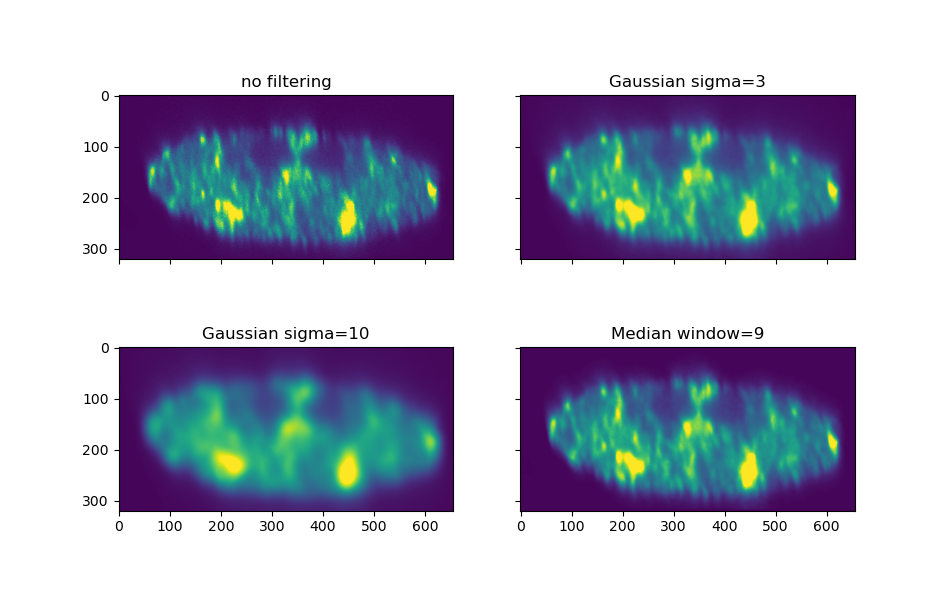

Text(0.5, 1.0, 'Median window=9')

In [212]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(9.5, 6), sharex=True, sharey=True)
clim = [0, np.quantile(baseline_0, .99)]
axs[0,0].imshow(baseline_0, clim=clim)
axs[0,0].set_title("no filtering")
axs[0,1].imshow(baseline_3, clim=clim)
axs[0,1].set_title("Gaussian sigma=3")
axs[1,0].imshow(baseline_10, clim=clim)
axs[1,0].set_title("Gaussian sigma=10")
axs[1,1].imshow(baseline_med, clim=clim)
axs[1,1].set_title("Median window=9")

In [209]:
baseline_0.shape

(320, 656)

# check dff baseline of 210427/210423/210415

In [331]:
fly_dir = os.path.join(load.NAS_DIR, "LH", "210415", "J1M5_fly2") 
# "210423_caffeine", "J1M5_fly2"# "210427_caffeine", "J1M5_fly1"
fly_processed_dir = os.path.join(fly_dir, load.PROCESSED_FOLDER)
summary_dff_denoised_baseline_dir = os.path.join(fly_processed_dir, "dff_baseline_denoised.tif")
summary_dff_baseline_dir = os.path.join(fly_processed_dir, "dff_baseline.tif")
trial_names = ["cs_003", "cs_water", "cs_water_after_001", "cs_water_after_003"]
# ["cs_001", "cs_caff", "cs_caff_after", "cs_caff_after_006"]  # "cs_002", "cs_caff", "cs_caff_after", "cs_caff_after_006"
trial_dirs = [os.path.join(fly_dir, trial_name) for trial_name in trial_names]
trial_processed_dirs = [os.path.join(trial_dir, load.PROCESSED_FOLDER) for trial_dir in trial_dirs]
dff_denoised_baseline_dirs = [os.path.join(processed_dir, "dff_baseline_denoised.tif") for processed_dir in trial_processed_dirs]
dff_baseline_dirs = [os.path.join(processed_dir, "dff_baseline.tif") for processed_dir in trial_processed_dirs]


In [332]:
summary_dff_baseline = utils2p.load_img(summary_dff_baseline_dir)
summary_dff_denoised_baseline = utils2p.load_img(summary_dff_denoised_baseline_dir)
dff_baselines = [utils2p.load_img(dff_baseline_dir) for dff_baseline_dir in dff_baseline_dirs]
dff_denoised_baselines = [utils2p.load_img(dff_baseline_dir) for dff_baseline_dir in dff_denoised_baseline_dirs]



<IPython.core.display.Javascript object>


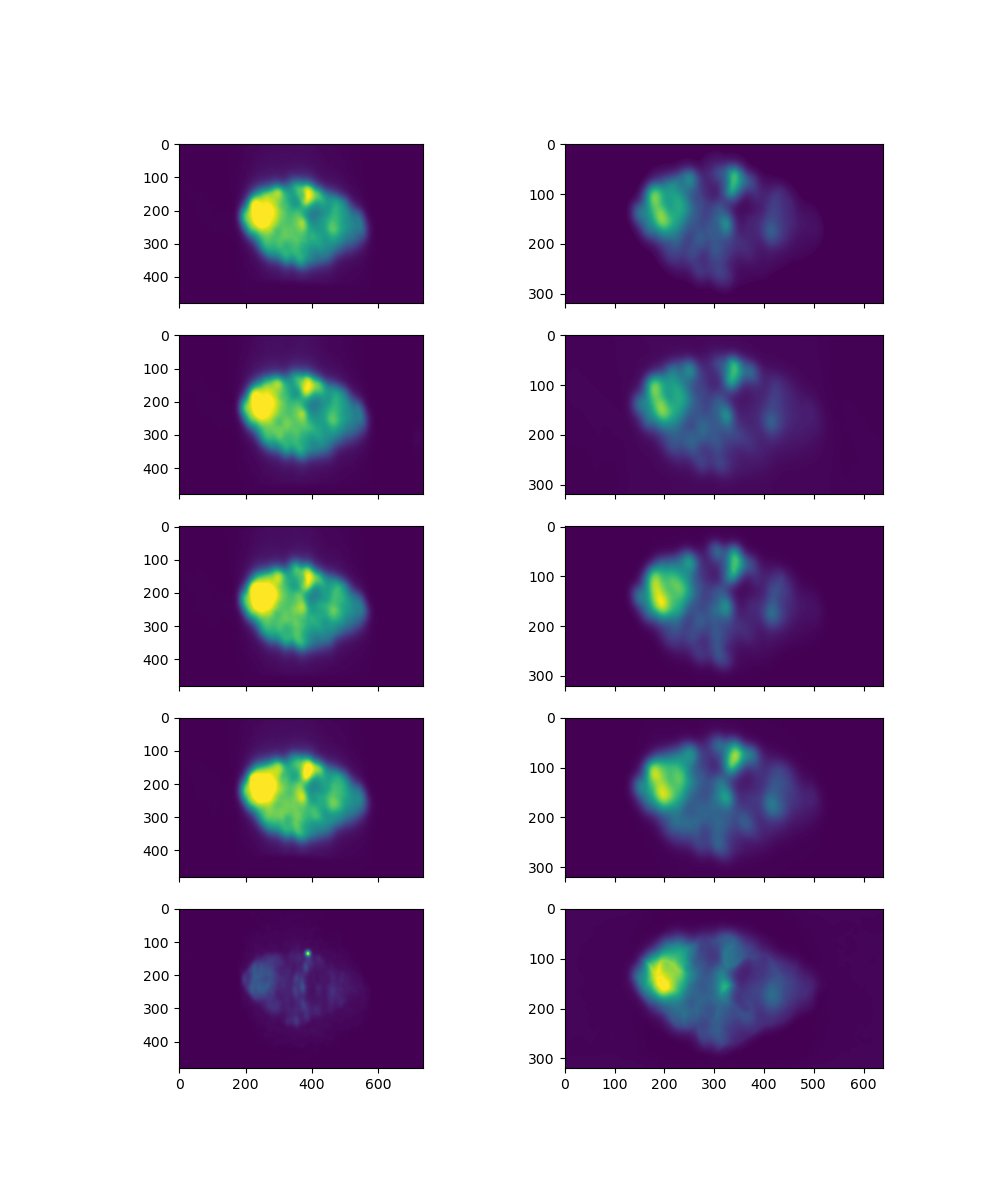

In [333]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10,12), sharex="col", sharey="col")

clim = [0, np.quantile(summary_dff_baseline, 0.99)]

axs[0,0].imshow(summary_dff_baseline, clim=clim)
axs[0,1].imshow(summary_dff_denoised_baseline, clim=clim)
for i_trial in range(4):
    axs[i_trial+1,0].imshow(dff_baselines[i_trial], clim=clim)
    axs[i_trial+1,1].imshow(dff_denoised_baselines[i_trial], clim=clim)

176, 240<br>
166, 312

In [334]:
trial_processed_dirs

['/mnt/NAS/LH/210415/J1M5_fly2/cs_003/processed',
 '/mnt/NAS/LH/210415/J1M5_fly2/cs_water/processed',
 '/mnt/NAS/LH/210415/J1M5_fly2/cs_water_after_001/processed',
 '/mnt/NAS/LH/210415/J1M5_fly2/cs_water_after_003/processed']

In [335]:
greens_raw = [utils2p.load_img(os.path.join(trial_processed_dirs[i], "green_com_warped.tif"))[30:-30,:,:] for i in range(4)]
greens_denoised = [utils2p.load_img(os.path.join(trial_processed_dirs[i], "green_denoised.tif")) for i in range(4)]

In [345]:
greens_denoised_cs2 = [utils2p.load_img(os.path.join(trial_processed_dirs[i], "green_denoised_t1.tif")) for i in range(4)]

In [336]:
raw_stds = [np.std(green_raw, axis=(0)) for green_raw in greens_raw]
denoised_stds = [np.std(green_denoised, axis=(0)) for green_denoised in greens_denoised]

In [346]:
denoised_cs2_stds = [np.std(green_denoised, axis=(0)) for green_denoised in greens_denoised_cs2]

In [337]:
print(raw_stds[0].shape)
print(denoised_stds[0].shape)

(480, 736)
(320, 640)


In [338]:
print((384-320)/2)
print((480-320)/2)
print((736-640)/2)

32.0
80.0
48.0


<IPython.core.display.Javascript object>


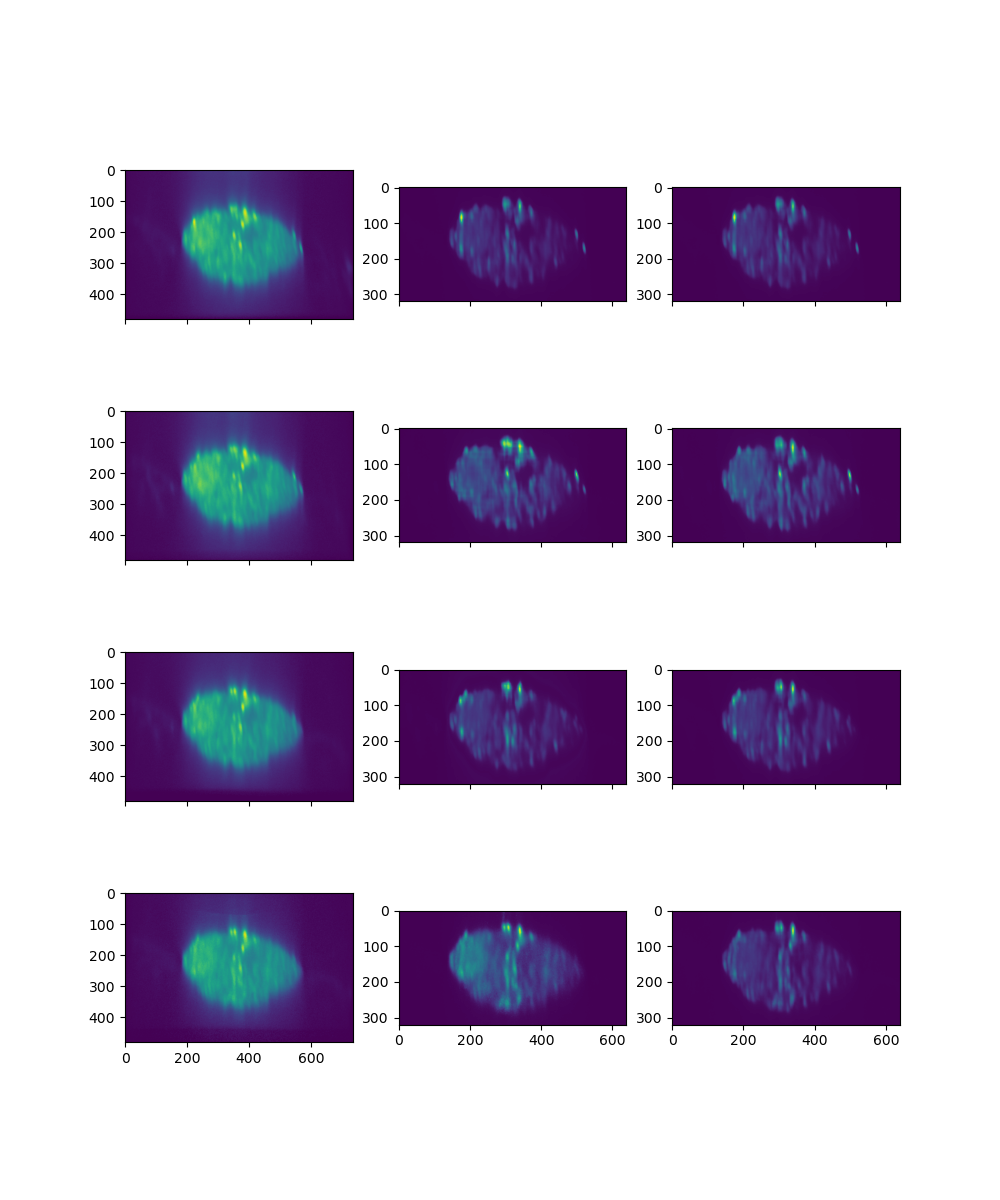

In [347]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,12), sharex="col", sharey="col")
for i_trial in range(4):
    axs[i_trial, 0].imshow(raw_stds[i_trial])
    axs[i_trial, 1].imshow(denoised_stds[i_trial])
    axs[i_trial, 2].imshow(denoised_cs2_stds[i_trial])

<IPython.core.display.Javascript object>


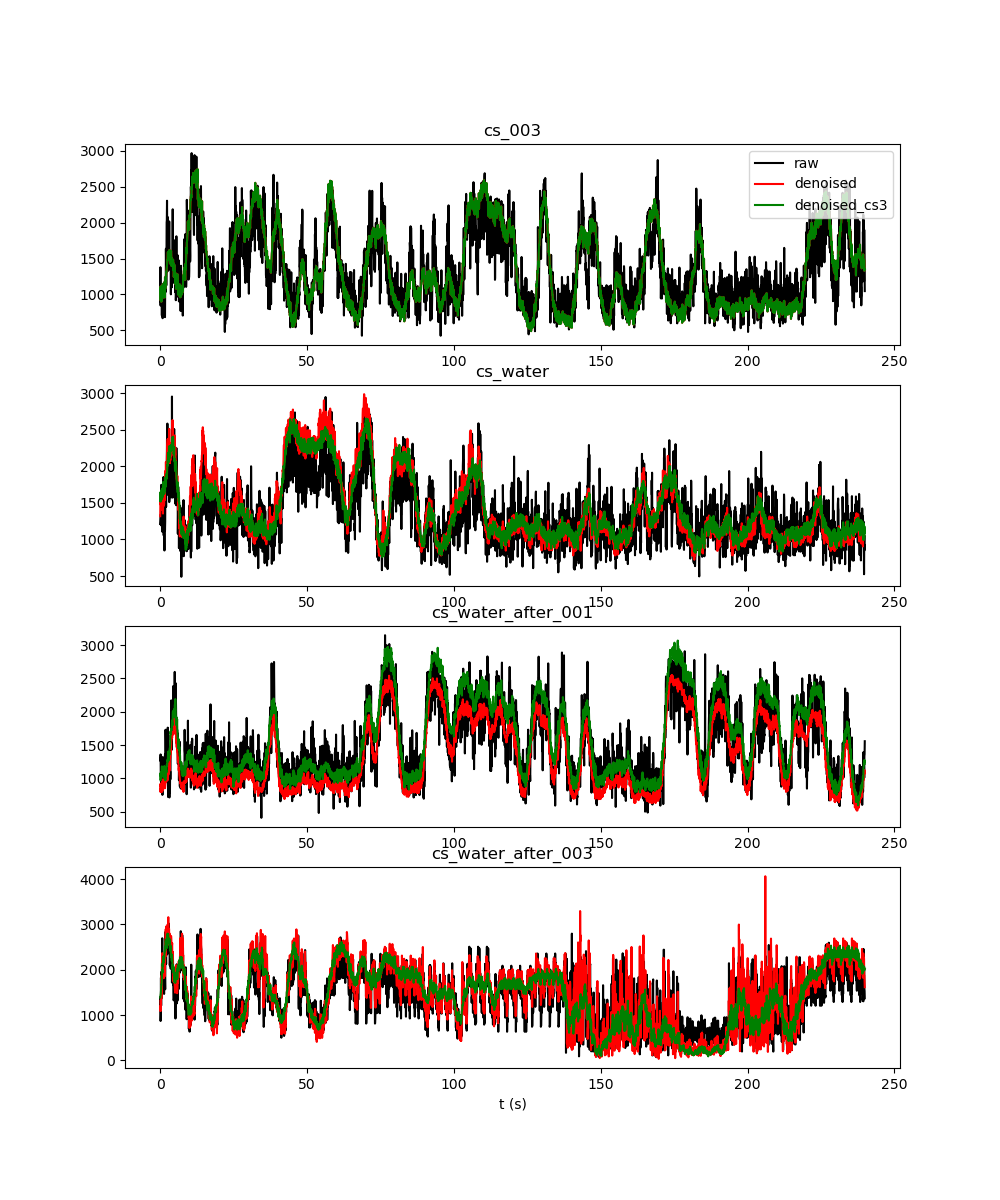

In [350]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,12))  # , sharex=True, sharey=True)
roi = [54, 339]  # [127, 304]  # [54, 339] # 210423 [91, 107]  # [92, 348] #  210427 [176, 240]  # [166, 312]  # [176, 240]
roi_size = 5
y_offset = 80  # 32
x_offset = 48  # 0
for i_trial in range(4):
    raw = np.mean(greens_raw[i_trial][:, y_offset+roi[0]-roi_size:y_offset+roi[0]+roi_size, 
                                      x_offset+roi[1]-roi_size:x_offset+roi[1]+roi_size], axis=(-2, -1))
    denoised = np.mean(greens_denoised[i_trial][:, roi[0]-roi_size:roi[0]+roi_size, 
                                                roi[1]-roi_size:roi[1]+roi_size], axis=(-2, -1))
    denoised_cs2 = np.mean(greens_denoised_cs2[i_trial][:, roi[0]-roi_size:roi[0]+roi_size, roi[1]-roi_size:roi[1]+roi_size], axis=(-2, -1))
    t = np.arange(len(raw)) / 16
    axs[i_trial].plot(t, raw, "k", label="raw")
    axs[i_trial].plot(t, denoised, "r", label="denoised")
    axs[i_trial].plot(t, denoised_cs2, "g", label="denoised_cs3")
    axs[i_trial].set_title(trial_names[i_trial])
    if i_trial == 0:
        axs[i_trial].legend()
    elif i_trial == 3:
        axs[i_trial].set_xlabel("t (s)")